In [1]:
import re, time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
from src.data import Dataset
from collections import OrderedDict
from sklearn.metrics import confusion_matrix, classification_report

from src.model import DNN

In [2]:
def find_gpu():
    device_list = device_lib.list_local_devices()
    for device in device_list:
        if re.match('/device:GPU', device.name):
            return 0
    return -1

In [3]:
gpu = find_gpu()
gpu = "/gpu:{}".format(gpu) if gpu >= 0 else "/cpu:0"

In [4]:
# dataset
dataset = Dataset(name='mnist')

In [5]:
model = DNN(name='DNN',
            input_shape=dataset.input_shape,
            out_dim=dataset.output_dim,
            opt="Adam",
            lr=0.001,
            l2_reg=False,
            l2_reg_scale=0.0005)

In [6]:
class Trainer():
    def __init__(self,
                 data,
                 model,
                 name,
                 n_epoch=100,
                 batch_size=32,
                 gpu=False,
                 ):
        self.data = data
        self.model = model
        self.name = name
        self.n_epoch = n_epoch
        self.batch_size = batch_size
        self.device = gpu
        self.train_loss = tf.keras.metrics.Mean(name='train_loss')
        self.test_loss = tf.keras.metrics.Mean(name='test_loss')
        self.acc_func = tf.keras.metrics.CategoricalAccuracy()

    def load(self, perm=False):
        train, valid, test = self.data.get()
        (x_train, y_train), (x_valid, y_valid), (x_test, y_test) = train, valid, test
        train_dataset = self.data.load(x_train, y_train, batch_size=self.batch_size, is_training=True)
        valid_dataset = self.data.load(x_valid, y_valid, batch_size=1000, is_training=False)
        test_dataset = self.data.load(x_test, y_test, batch_size=1000, is_training=False)
        return train_dataset, valid_dataset, test_dataset

    @tf.function
    def _train_body(self, images, labels, continual=0):
        with tf.device(self.device):
            with tf.GradientTape(persistent=True) as tape:
                with tf.name_scope('train_logits'):
                    y_pre = self.model(images, trainable=True)
                with tf.name_scope('train_loss'):
                    loss = self.model.loss(y_pre, labels, tape, self.method if continual > 0 else None)
                self.train_loss(loss)
            self.model.optimize(loss, tape)#, other_variables=tokens[-1])
            with tf.name_scope('train_accuracy'):
                self.acc_func(y_true=labels, y_pred=y_pre)
        return

    def train(self):
        # load dataset
        train_dataset, valid_dataset, test_dataset = self.load()
        self.data.create_mncode()
        total_epoch = 1
        for epoch in range(self.n_epoch):
            start_time = time.time()
            for (train_images, train_labels) in train_dataset:
                train_images = self.data.add_mncode(train_images, train_labels)
                self._train_body(train_images,
                                 train_labels
                                 )
            time_per_episode = time.time() - start_time

            # trainiing metricsを記録
            train_loss = self.train_loss.result().numpy()
            train_accuracy = self.acc_func.result().numpy()
            # 訓練履歴のリセット
            self.train_loss.reset_states()
            self.acc_func.reset_states()

            test_losses, test_accuracy, average_accuracy = [], [], []
            for (test_images, test_labels) in test_dataset:
                self._test_body(test_images, test_labels)

            # test lossを記録
            test_losses.append(self.test_loss.result().numpy())
            test_accuracy.append(self.acc_func.result().numpy())

            # 訓練履歴のリセット
            self.test_loss.reset_states()
            self.acc_func.reset_states()

            # Training results
            metrics = OrderedDict({
                "epoch": total_epoch,
                "train_loss": train_loss,
                "train_accuracy":train_accuracy,
                "test_loss": test_losses,
                "test_accuracy" : test_accuracy,
                "time/epoch": time_per_episode
            })

            total_epoch += 1
            self.epoch_end(metrics, None)

        true_classes, predict_classes = [], []
        for (test_images, test_labels) in test_dataset:
            true_class, predict_class = self._test_body(test_images, test_labels)
            true_classes.append(true_class)
            predict_classes.append(predict_class)
    
        true_classes = np.hstack(true_classes)
        predict_classes = np.hstack(predict_classes)
        self.aggregate_result(pred=predict_classes, truth=true_classes, graph=True)
        

    def forget(self, class_num, dataset=None, alpha=None):
        # load dataset
        if dataset is None:
            _, dataset, _ = self.load()

        # get forgetting data and retain data
        retain_data = self.data.mncode.copy()
        forget_data = retain_data.pop(class_num)

        classidx = np.arange(self.data.output_dim)
        forget_class = tf.one_hot(classidx[class_num], self.data.output_dim)
        retain_class = tf.one_hot(np.delete(classidx, class_num, 0), self.data.output_dim)

        # 
        posi_weight_list, nega_weight_list = self.model.mn_forget(forget_data=forget_data,
                                                                forget_class=forget_class,
                                                                retain_data=retain_data,
                                                                retain_class=retain_class,
                                                                alpha=alpha if alpha is not None else 1.
                                                                )

        # 推論
        for param, target_param in zip(posi_weight_list, self.model.weights):
            target_param.assign(param)

        true_classes, predict_classes = [], []
        for (images, labels) in dataset:
            true_class, predict_class = self._test_body(images, labels)
            true_classes.append(true_class)
            predict_classes.append(predict_class)
        
        true_classes = np.hstack(true_classes)
        predict_classes = np.hstack(predict_classes)
        self.aggregate_result(pred=predict_classes, truth=true_classes, graph=True)
        
        

        for param, target_param in zip(nega_weight_list, self.model.weights):
            target_param.assign(param)

        true_classes, predict_classes = [], []
        for (images, labels) in dataset:
            true_class, predict_class = self._test_body(images, labels)
            true_classes.append(true_class)
            predict_classes.append(predict_class)

        true_classes = np.hstack(true_classes)
        predict_classes = np.hstack(predict_classes)

        self.aggregate_result(pred=predict_classes, truth=true_classes, graph=True)

        return posi_weight_list, nega_weight_list

    @tf.function
    def _test_body(self, images, labels):
        with tf.device(self.device):
            with tf.name_scope('test_logits'):
                y_pre = self.model(images, trainable=False)
            with tf.name_scope('test_loss'):
                loss = self.model.loss(y_pre, labels)
                self.test_loss(loss)
            with tf.name_scope('test_accuracy'):
                self.acc_func(y_true=labels, y_pred=y_pre)

        true_classes = tf.argmax(labels, 1)
        predict_classes = tf.argmax(y_pre, 1)
        return true_classes, predict_classes


    def epoch_end(self, metrics, other=None):
        print_format = "epoch: %d  train_loss: %.4f  train_acc: %.3f  "%(metrics['epoch'], metrics['train_loss'], metrics['train_accuracy'])
        learning_rate = self.model.optimizer.lr(metrics['epoch']).numpy() if type(self.model.optimizer.lr) is tf.optimizers.schedules.ExponentialDecay else self.model.optimizer.lr
        
        for i, (loss, acc) in enumerate(zip(metrics['test_loss'], metrics['test_accuracy'])):
            print_format += "test_loss{0:1d}: {1:.4f}  test_acc{0:1d}: {2:.3f}  ".format(i, loss, acc)

        print_format += "time/epoch: %0.3fs"%metrics['time/epoch']
        print(print_format)
        return

    def aggregate_result(self, pred, truth, graph=False):
        target_names = ['num:{}'.format(i) for i in range(self.data.output_dim)]
        rep = classification_report(truth, pred, target_names=target_names, output_dict=True)
        df = pd.DataFrame(rep).T
        print(df)
        if graph:
            plt.figure(figsize=(10, 8))
            left = np.array(target_names)
            height = np.array(df["precision"])[:len(target_names)] * 100
            plt.bar(left, height)
            plt.ylim([0, 100])
            plt.show()
        return

epoch: 1  train_loss: 0.1305  train_acc: 0.965  test_loss0: 0.1424  test_acc0: 0.956  time/epoch: 13.677s
epoch: 2  train_loss: 0.0867  train_acc: 0.973  test_loss0: 0.1172  test_acc0: 0.962  time/epoch: 13.296s
epoch: 3  train_loss: 0.0695  train_acc: 0.979  test_loss0: 0.1087  test_acc0: 0.966  time/epoch: 13.325s
epoch: 4  train_loss: 0.0607  train_acc: 0.982  test_loss0: 0.1209  test_acc0: 0.963  time/epoch: 13.261s
epoch: 5  train_loss: 0.0544  train_acc: 0.983  test_loss0: 0.1051  test_acc0: 0.967  time/epoch: 13.296s
              precision    recall  f1-score     support
num:0          0.965278  0.992857  0.978873    980.0000
num:1          0.980786  0.989427  0.985088   1135.0000
num:2          0.978894  0.943798  0.961026   1032.0000
num:3          0.965347  0.965347  0.965347   1010.0000
num:4          0.967314  0.964358  0.965834    982.0000
num:5          0.976163  0.964126  0.970107    892.0000
num:6          0.961934  0.975992  0.968912    958.0000
num:7          0.97797

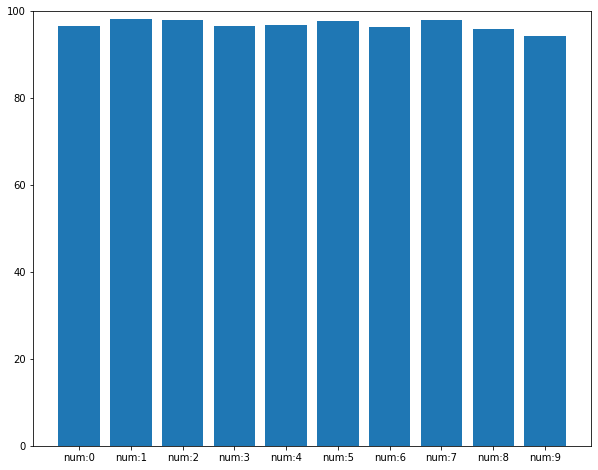

In [11]:
trainer = Trainer(data=dataset, n_epoch=5, batch_size=32, gpu=gpu, model=model, name='DNN')
trainer.train()

              precision    recall  f1-score       support
num:0          1.000000  0.012116  0.023941   1073.000000
num:1          0.000000  0.000000  0.000000   1164.000000
num:2          0.953488  0.036283  0.069906   1130.000000
num:3          0.000000  0.000000  0.000000   1036.000000
num:4          1.000000  0.003119  0.006218    962.000000
num:5          0.000000  0.000000  0.000000    922.000000
num:6          1.000000  0.025666  0.050048   1013.000000
num:7          0.909091  0.009066  0.017953   1103.000000
num:8          0.099962  1.000000  0.181755   1040.000000
num:9          0.000000  0.000000  0.000000   1057.000000
accuracy       0.107905  0.107905  0.107905      0.107905
macro avg      0.496254  0.108625  0.034982  10500.000000
weighted avg   0.498298  0.107905  0.035256  10500.000000


/Users/nakane/opt/anaconda3/envs/tf2.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


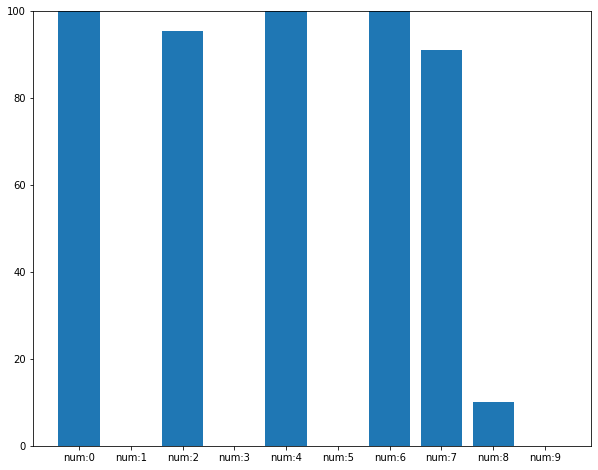

              precision    recall  f1-score      support
num:0          0.774381  0.991612  0.869636   1073.00000
num:1          0.890769  0.994845  0.939935   1164.00000
num:2          0.716359  0.961062  0.820862   1130.00000
num:3          0.813644  0.944015  0.873995   1036.00000
num:4          0.927593  0.985447  0.955645    962.00000
num:5          0.988811  0.766811  0.863775    922.00000
num:6          0.838198  0.992103  0.908680   1013.00000
num:7          0.893652  0.982774  0.936097   1103.00000
num:8          0.000000  0.000000  0.000000   1040.00000
num:9          0.974974  0.884579  0.927579   1057.00000
accuracy       0.853810  0.853810  0.853810      0.85381
macro avg      0.781838  0.850325  0.809620  10500.00000
weighted avg   0.779958  0.853810  0.810422  10500.00000


/Users/nakane/opt/anaconda3/envs/tf2.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


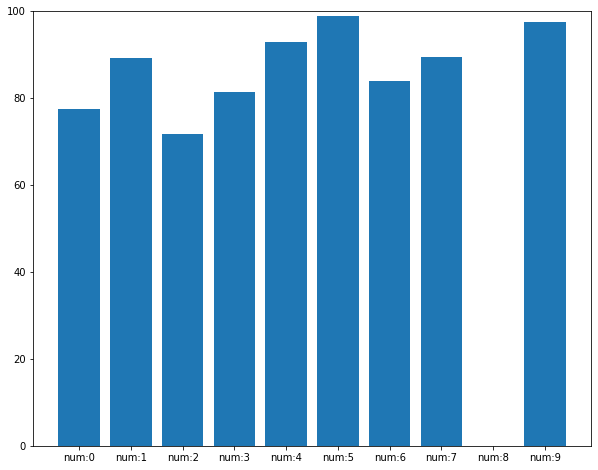

In [13]:
posi_weight_list, nega_weight_list = trainer.forget(class_num=8)

              precision    recall  f1-score       support
num:0          0.000000  0.000000  0.000000   1001.000000
num:1          0.976231  0.945724  0.960735   1216.000000
num:2          0.992634  0.488667  0.654921   1103.000000
num:3          1.000000  0.046238  0.088388   1103.000000
num:4          0.992013  0.586957  0.737530   1058.000000
num:5          0.126670  1.000000  0.224858    910.000000
num:6          0.991176  0.326234  0.490896   1033.000000
num:7          0.948276  0.104563  0.188356   1052.000000
num:8          0.968127  0.243000  0.388489   1000.000000
num:9          0.886256  0.182617  0.302834   1024.000000
accuracy       0.395048  0.395048  0.395048      0.395048
macro avg      0.788138  0.392400  0.403701  10500.000000
weighted avg   0.804468  0.395048  0.416847  10500.000000


/Users/nakane/opt/anaconda3/envs/tf2.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


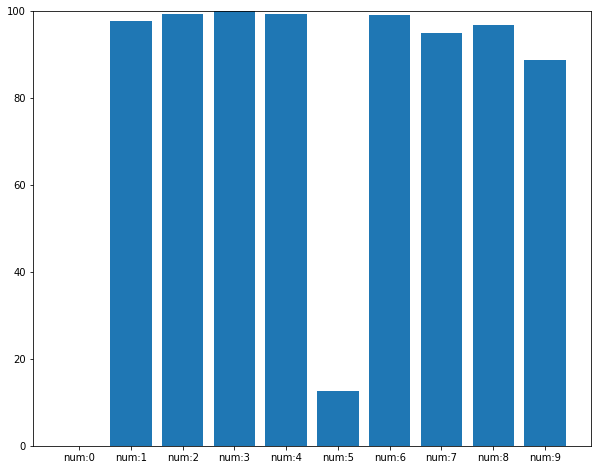

              precision    recall  f1-score       support
num:0          0.951597  0.982018  0.966568   1001.000000
num:1          0.976993  0.977796  0.977394   1216.000000
num:2          0.961646  0.932004  0.946593   1103.000000
num:3          0.826018  0.938350  0.878608   1103.000000
num:4          0.966926  0.939509  0.953020   1058.000000
num:5          0.000000  0.000000  0.000000    910.000000
num:6          0.929358  0.980639  0.954310   1033.000000
num:7          0.983135  0.942015  0.962136   1052.000000
num:8          0.554989  0.979000  0.708394   1000.000000
num:9          0.921002  0.933594  0.927255   1024.000000
accuracy       0.873143  0.873143  0.873143      0.873143
macro avg      0.807166  0.860492  0.827428  10500.000000
weighted avg   0.821691  0.873143  0.841277  10500.000000


/Users/nakane/opt/anaconda3/envs/tf2.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


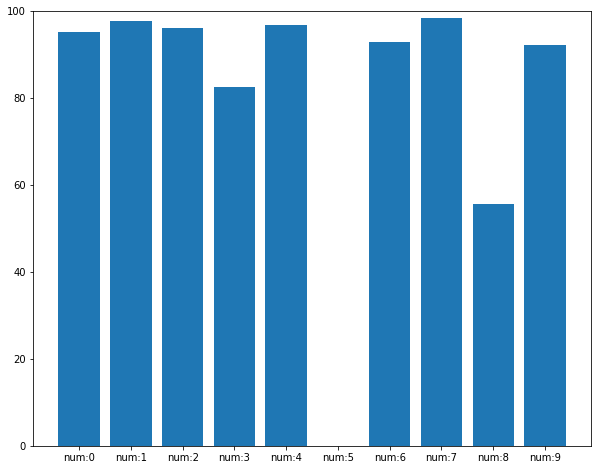

In [8]:
posi_weight_list, nega_weight_list = trainer.forget(class_num=0, alpha=1.12)

In [9]:
#for param, target_param in zip(nega_weight_list, trainer.model.weights):
#    target_param.assign(param)

#posi_weight_list, nega_weight_list = trainer.forget(class_num=1)